In [104]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.load_datasets import load_datasets
from functions.calculate_monthly_returns import calculate_monthly_returns

In [105]:
base_path = str(project_root) + "/data/"
df_pbr, df_stp, df_mktcap = load_datasets(base_path)
df_returns = calculate_monthly_returns(df_stp)
# リスクフリーレート
rf_df = pd.read_csv(base_path + "rf.csv", header=None).iloc[:, [0,2]].rename(columns={0: "date", 2: "rf"}).set_index("date")

In [106]:
# データ構造の確認
print("df_pbrの形状:", df_pbr.shape)
print("df_stpの形状:", df_stp.shape)

df_pbrの形状: (3474, 73)
df_stpの形状: (3474, 73)


In [107]:
# PBRによる5分位ポートフォリオ構築
def create_quintile_portfolios(df_pbr, df_returns, n_quintiles=5, start_date=None):
    """
    PBRで5分位ポートフォリオを構築し、各分位の月次リターンを計算

    Parameters:
    -----------
    df_pbr : DataFrame
        PBRデータ
    df_returns : DataFrame
        リターンデータ
    n_quintiles : int
        分位数（デフォルト: 5）
    start_date : str
        開始日（YYYY/MM形式、デフォルト: None=全期間）
    """
    # PBRの日付列を取得
    pbr_cols = [col for col in df_pbr.columns if col != 'Company']

    # リターン列を取得
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    # 結果を格納する辞書
    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    # 各月について処理
    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]  # ポートフォリオ形成月のPBR
        return_month = return_cols[i]  # 翌月のリターン
        date_str = return_month.replace('ret_', '')

        # 開始日以前のデータはスキップ
        if start_date is not None and date_str < start_date:
            continue

        # 形成月の日付を取得
        portfolio_returns['Date'].append(date_str)

        # PBRとリターンをマージ
        temp_df = pd.DataFrame({
            'Company': df_pbr['Company'],
            'PBR': df_pbr[formation_month],
            'Return': df_returns[return_month]
        })

        # 欠損値を除外
        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # PBRで5分位に分割（Q1が最も低いPBR = バリュー株）
        temp_df['Quintile'] = pd.qcut(temp_df['PBR'], q=n_quintiles, labels=False, duplicates='drop')

        # 各分位の等加重平均リターンを計算
        for q in range(n_quintiles):
            quintile_returns = temp_df[temp_df['Quintile'] == q]['Return']
            avg_return = quintile_returns.mean() if len(quintile_returns) > 0 else np.nan
            portfolio_returns[f'Q{q+1}'].append(avg_return)

    # DataFrameに変換
    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# 5分位ポートフォリオを構築（2020/08から開始、ML戦略と期間を揃える）
START_DATE = '2020/08'
quintile_returns = create_quintile_portfolios(df_pbr, df_returns, n_quintiles=5, start_date=START_DATE)

print("5分位ポートフォリオの月次リターン")
print(f"データ期間: {quintile_returns.index[0]} ～ {quintile_returns.index[-1]}")
print(f"観測数: {len(quintile_returns)}")
print(f"\n基本統計量:")
print(quintile_returns.describe())

5分位ポートフォリオの月次リターン
データ期間: 2020/08 ～ 2025/12
観測数: 65

基本統計量:
              Q1         Q2         Q3         Q4         Q5
count  65.000000  65.000000  65.000000  65.000000  65.000000
mean    0.015824   0.013796   0.012548   0.008553   0.004530
std     0.027809   0.026723   0.028849   0.031177   0.042229
min    -0.047742  -0.056069  -0.054833  -0.074670  -0.141861
25%    -0.004496  -0.000834  -0.003263  -0.006333  -0.017973
50%     0.018532   0.015079   0.012593   0.008763   0.006422
75%     0.035500   0.030457   0.029112   0.029837   0.036648
max     0.070397   0.070165   0.091404   0.100542   0.124386


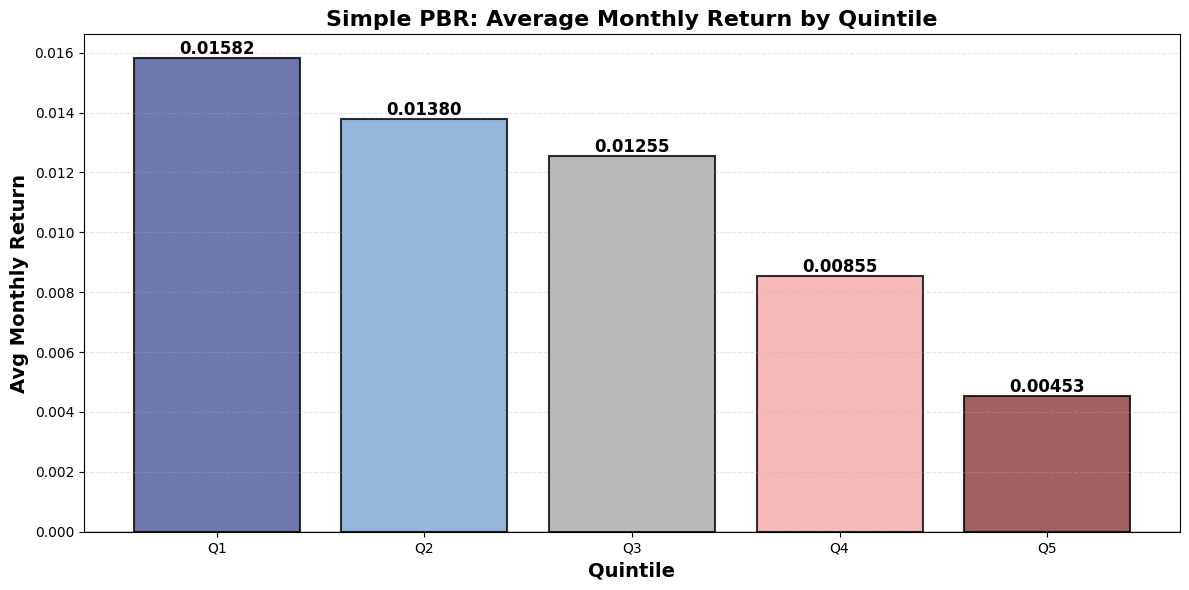


各分位の平均月次リターン:
Q1: 0.01582 (1.582%)
Q2: 0.01380 (1.380%)
Q3: 0.01255 (1.255%)
Q4: 0.00855 (0.855%)
Q5: 0.00453 (0.453%)


In [108]:
# 図1: 平均月次リターンのヒストグラム（棒グラフ）
plt.figure(figsize=(12, 6))

mean_returns = quintile_returns.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns.index, mean_returns.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('Simple PBR: Average Monthly Return by Quintile', fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

# 値をバーの上に表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン:")
for q, ret in mean_returns.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

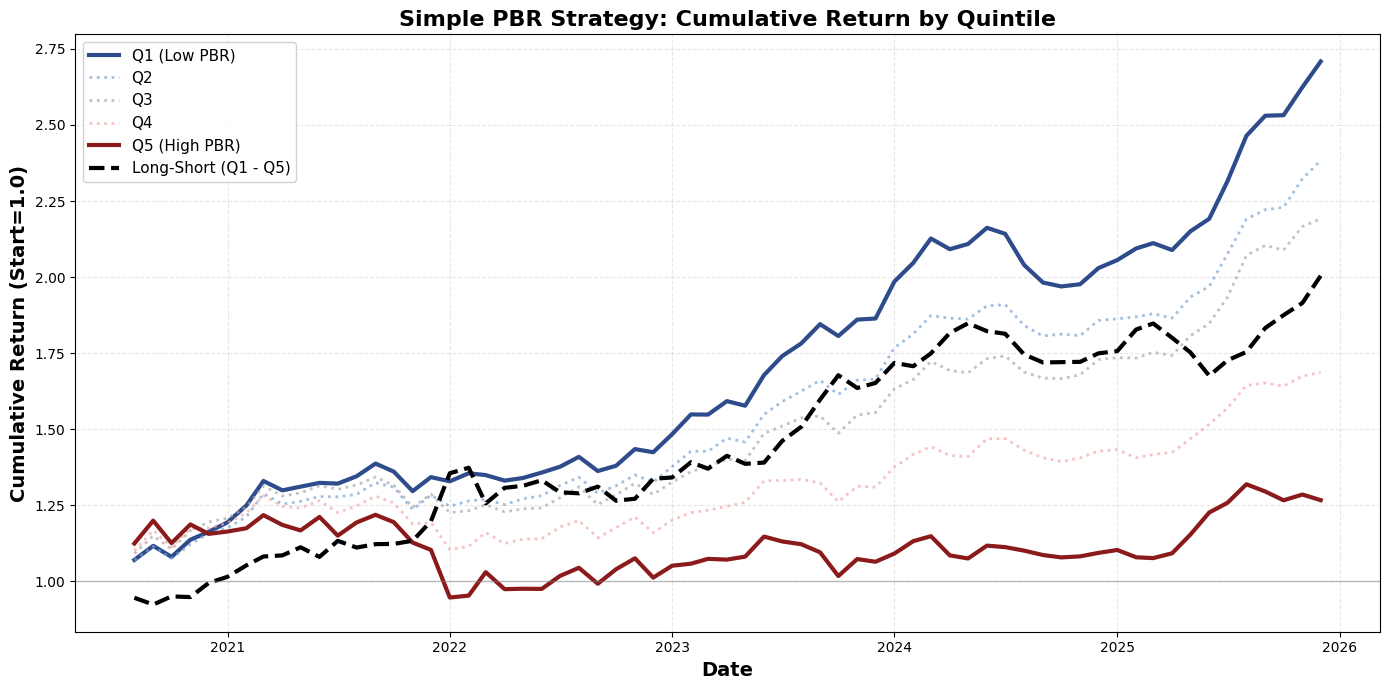


最終累積リターン（開始=1.0）:
Q1: 2.7085 (累積リターン: +170.85%)
Q2: 2.3827 (累積リターン: +138.27%)
Q3: 2.1914 (累積リターン: +119.14%)
Q4: 1.6868 (累積リターン: +68.68%)
Q5: 1.2668 (累積リターン: +26.68%)
Long-Short (Q1-Q5): 2.0041 (累積リターン: +100.41%)


In [109]:
# 図2: 累積リターンの推移（TOPIXと比較）
plt.figure(figsize=(14, 7))

# 累積リターンを計算（1から始まる）
# リターンはパーセントで格納されているので、100で割って小数に変換
cumulative_returns = (1 + quintile_returns).cumprod()

# Long-Short (Q1 - Q5) ポートフォリオの累積リターン
long_short_returns = quintile_returns['Q1'] - quintile_returns['Q5']
cumulative_long_short = (1 + long_short_returns).cumprod()

# 日付インデックスをdatetimeに変換
dates = pd.to_datetime(cumulative_returns.index, format='%Y/%m')

# 各分位の累積リターンをプロット
plt.plot(dates, cumulative_returns['Q1'], linewidth=3, color='#2E4C8B', label='Q1 (Low PBR)', linestyle='-')
plt.plot(dates, cumulative_returns['Q2'], linewidth=2, color='#7AA5D2', label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q3'], linewidth=2, color='#A8A8A8', label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q4'], linewidth=2, color='#F4A8A8', label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q5'], linewidth=3, color='#8B1A1A', label='Q5 (High PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short, linewidth=3, color='black', label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('Simple PBR Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターンの表示
print("\n最終累積リターン（開始=1.0）:")
for col in cumulative_returns.columns:
    final_return = cumulative_returns[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls = cumulative_long_short.iloc[-1]
total_ls_pct = (final_ls - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls:.4f} (累積リターン: {total_ls_pct:+.2f}%)")

In [110]:
# バリュープレミアムの統計分析
value_premium = quintile_returns['Q1'] - quintile_returns['Q5']

print("\n" + "=" * 80)
print("バリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium.mean():.5f} ({value_premium.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium.std():.5f}")
print(f"t値: {value_premium.mean() / (value_premium.std() / np.sqrt(len(value_premium))):.4f}")

# t検定
from scipy import stats
t_stat, p_value = stats.ttest_1samp(value_premium.dropna(), 0)
print(f"p値: {p_value:.6f}")

if p_value < 0.01:
    sig = '***'
elif p_value < 0.05:
    sig = '**'
elif p_value < 0.1:
    sig = '*'
else:
    sig = ''

print(f"有意性: {sig} ({'有意' if sig else '有意でない'})")
print("=" * 80)


バリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.01129 (1.129%)
標準偏差: 0.03336
t値: 2.7292
p値: 0.008189
有意性: *** (有意)


In [111]:
# シャープレシオの計算
print("\n" + "=" * 80)
print("シャープレシオの計算")
print("=" * 80)

rf_monthly = rf_df['rf'] / 100

# 各分位のシャープレシオ
sharpe_ratios = {}
for col in quintile_returns.columns:
    excess_returns = quintile_returns[col].copy()
    for idx in excess_returns.index:
        if idx in rf_monthly.index:
            excess_returns[idx] = excess_returns[idx] - rf_monthly[idx]

    mean_return = excess_returns.mean()
    std_return = excess_returns.std()
    # 月次シャープレシオ
    sharpe_monthly = mean_return / std_return if std_return > 0 else 0
    # 年率換算シャープレシオ = 月次シャープレシオ × sqrt(12)
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略のシャープレシオ
ls_mean = value_premium.mean()
ls_std = value_premium.std()
ls_sharpe_monthly = ls_mean / ls_std if ls_std > 0 else 0
ls_sharpe_annual = ls_sharpe_monthly * np.sqrt(12)

sharpe_ratios['Long-Short (Q1-Q5)'] = {
    '月次': ls_sharpe_monthly,
    '年率換算': ls_sharpe_annual
}

# 結果を表示
sharpe_df = pd.DataFrame(sharpe_ratios).T
print("\nシャープレシオ:")
print(sharpe_df.to_string())

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = 平均リターン / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("=" * 80)


シャープレシオの計算

シャープレシオ:
                          月次      年率換算
Q1                  0.537020  1.860291
Q2                  0.483480  1.674825
Q3                  0.404940  1.402753
Q4                  0.245677  0.851049
Q5                  0.086169  0.298496
Long-Short (Q1-Q5)  0.338512  1.172640

解釈:
--------------------------------------------------------------------------------
- シャープレシオ = 平均リターン / リターンの標準偏差
- リスク調整後のパフォーマンスを測定
- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる


In [113]:
# ===================================================================
# Carhart 4ファクターモデルによる回帰分析
# ===================================================================
import statsmodels.api as sm

print("=" * 80)
print("Carhart 4ファクターの構築")
print("=" * 80)

# 時価総額データの列名を時系列順に並び替える関数
def sort_columns_chronologically(df):
    """列名を時系列順に並び替える"""
    cols = df.columns.tolist()
    company_col = 'Company' if 'Company' in cols else None
    date_cols = [col for col in cols if col != 'Company']
    date_cols_sorted = sorted(date_cols)
    if company_col:
        return df[['Company'] + date_cols_sorted]
    return df[date_cols_sorted]

# 時価総額データの列名を変換（P, P-1形式 → 年月形式）
def rename_mktcap_columns(df_mktcap, df_pbr):
    """時価総額の列名をPBRの列名に合わせて変換"""
    mktcap_cols = [col for col in df_mktcap.columns if col != 'Company']
    p_cols = [col for col in mktcap_cols if col.startswith('P')]

    if len(p_cols) > 0:
        pbr_cols = [col for col in df_pbr.columns if col != 'Company']
        latest_year = int(pbr_cols[-1].split('/')[0])

        col_mapping = {}
        for p_col in p_cols:
            if p_col == 'P':
                year = latest_year
            else:
                offset = int(p_col.replace('P-', ''))
                year = latest_year - offset
            col_mapping[p_col] = f"{year}/03"

        df_renamed = df_mktcap.rename(columns=col_mapping)
        return df_renamed
    return df_mktcap

df_mktcap_renamed = rename_mktcap_columns(df_mktcap, df_pbr)
df_mktcap_sorted = sort_columns_chronologically(df_mktcap_renamed)

print(f"時価総額データの形状: {df_mktcap_sorted.shape}")

# Carhart 4ファクターの構築
def construct_carhart4_factors(df_pbr_sorted, df_stp_sorted, df_mktcap_sorted, df_returns, rf_df):
    """
    Carhart 4ファクターを構築

    Factors:
    1. Mkt-Rf: 市場超過リターン（時価総額加重市場リターン - リスクフリーレート）
    2. SMB (Small Minus Big): 小型株 - 大型株
    3. HML (High Minus Low): 低PBR株 - 高PBR株（バリュー - グロース）
    4. MOM (Momentum): 過去勝者 - 過去敗者（過去11ヶ月リターンで分類）
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    # リスクフリーレートの月次変換
    rf_monthly = rf_df['rf'] / 100

    factors = {
        'Date': [],
        'Mkt_Rf': [],
        'SMB': [],
        'HML': [],
        'MOM': [],
        'Rf': []
    }

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]
        date_str = return_month.replace('ret_', '')

        factors['Date'].append(date_str)

        # リスクフリーレートを取得
        rf_rate = rf_monthly.get(date_str, 0.0)
        factors['Rf'].append(rf_rate)

        # 時価総額データを取得
        if formation_month not in df_mktcap_sorted.columns:
            available_mktcap_cols = [col for col in df_mktcap_sorted.columns if col != 'Company' and col <= formation_month]
            if len(available_mktcap_cols) == 0:
                factors['Mkt_Rf'].append(np.nan)
                factors['SMB'].append(np.nan)
                factors['HML'].append(np.nan)
                factors['MOM'].append(np.nan)
                continue
            mktcap_month = available_mktcap_cols[-1]
        else:
            mktcap_month = formation_month

        # ===== モメンタムの計算（過去11ヶ月: t-12 から t-2） =====
        # 現在の月のインデックス
        current_idx = return_cols.index(return_month)

        # 過去11ヶ月のリターンを計算（t-12からt-2、直近1ヶ月は除外）
        if current_idx >= 12:
            past_return_cols = return_cols[current_idx-12:current_idx-1]  # t-12 to t-2

            # 各企業の過去11ヶ月累積リターンを計算
            returns_subset = df_returns.set_index('Company')[past_return_cols]
            past_cumret = (1 + returns_subset).prod(axis=1) - 1

            momentum_df = pd.DataFrame({
                'Company': past_cumret.index,
                'PastReturn': past_cumret.values
            }).set_index('Company')
        else:
            momentum_df = None

        # データを統合
        temp_df = pd.DataFrame({
            'Company': df_pbr_sorted['Company'],
            'PBR': df_pbr_sorted[formation_month],
            'MktCap': df_mktcap_sorted[mktcap_month],
            'Return': df_returns[return_month]
        })

        # モメンタムデータを結合
        if momentum_df is not None:
            temp_df = temp_df.set_index('Company').join(momentum_df, how='left').reset_index()
        else:
            temp_df['PastReturn'] = np.nan

        temp_df = temp_df.dropna()

        if len(temp_df) < 10:
            factors['Mkt_Rf'].append(np.nan)
            factors['SMB'].append(np.nan)
            factors['HML'].append(np.nan)
            factors['MOM'].append(np.nan)
            continue

        # 1. Mkt-Rf: 時価総額加重市場リターン - リスクフリーレート
        total_mktcap = temp_df['MktCap'].sum()
        temp_df['Weight'] = temp_df['MktCap'] / total_mktcap
        mkt_return = (temp_df['Weight'] * temp_df['Return']).sum()
        mkt_rf = mkt_return - rf_rate
        factors['Mkt_Rf'].append(mkt_rf)

        # 2. SMB: 時価総額で2分割
        median_mktcap = temp_df['MktCap'].median()
        small_stocks = temp_df[temp_df['MktCap'] <= median_mktcap]
        big_stocks = temp_df[temp_df['MktCap'] > median_mktcap]

        smb = small_stocks['Return'].mean() - big_stocks['Return'].mean()
        factors['SMB'].append(smb)

        # 3. HML: PBRで3分割（Low 30% vs High 30%）
        pbr_30 = temp_df['PBR'].quantile(0.3)
        pbr_70 = temp_df['PBR'].quantile(0.7)

        low_pbr = temp_df[temp_df['PBR'] <= pbr_30]  # Value
        high_pbr = temp_df[temp_df['PBR'] >= pbr_70]  # Growth

        hml = low_pbr['Return'].mean() - high_pbr['Return'].mean()
        factors['HML'].append(hml)

        # 4. MOM: 過去リターンで3分割（Winners 30% vs Losers 30%）
        if 'PastReturn' in temp_df.columns and temp_df['PastReturn'].notna().sum() > 10:
            mom_30 = temp_df['PastReturn'].quantile(0.3)
            mom_70 = temp_df['PastReturn'].quantile(0.7)

            losers = temp_df[temp_df['PastReturn'] <= mom_30]   # 過去の敗者
            winners = temp_df[temp_df['PastReturn'] >= mom_70]  # 過去の勝者

            mom = winners['Return'].mean() - losers['Return'].mean()
            factors['MOM'].append(mom)
        else:
            factors['MOM'].append(np.nan)

    factors_df = pd.DataFrame(factors).set_index('Date')
    return factors_df

# Carhart 4ファクターを構築
carhart_factors = construct_carhart4_factors(df_pbr, df_stp, df_mktcap_sorted, df_returns, rf_df)

print(f"\nファクターデータの形状: {carhart_factors.shape}")
print(f"期間: {carhart_factors.index[0]} ～ {carhart_factors.index[-1]}")
print(f"\n基本統計量:")
print(carhart_factors.describe())

Carhart 4ファクターの構築
時価総額データの形状: (4103, 22)

ファクターデータの形状: (71, 5)
期間: 2020/02 ～ 2025/12

基本統計量:
          Mkt_Rf        SMB        HML        MOM         Rf
count  59.000000  59.000000  59.000000  59.000000  71.000000
mean    0.009043  -0.000669   0.010477   0.003422   0.000791
std     0.026266   0.003306   0.027732   0.018312   0.001916
min    -0.043887  -0.007278  -0.067641  -0.082931  -0.000670
25%    -0.008968  -0.002852  -0.006508  -0.002752  -0.000345
50%     0.009278  -0.000912   0.006920   0.004533  -0.000170
75%     0.028739   0.002252   0.030180   0.012945   0.000775
max     0.060144   0.006240   0.109060   0.043790   0.005570


In [114]:
# Carhart 4ファクター回帰分析
print("\n" + "=" * 80)
print("Carhart 4ファクターモデルによる回帰分析（リスクフリーレート考慮）")
print("=" * 80)

# ロングショート戦略のリターンとファクターをマージ
regression_data = pd.DataFrame({
    'LS_Return': value_premium,
    'Mkt_Rf': carhart_factors['Mkt_Rf'],
    'SMB': carhart_factors['SMB'],
    'HML': carhart_factors['HML'],
    'MOM': carhart_factors['MOM'],
    'Rf': carhart_factors['Rf']
})

# 欠損値を除外
regression_data = regression_data.dropna()

print(f"\n回帰分析用データ:")
print(f"  サンプル数: {len(regression_data)}")
print(f"  期間: {regression_data.index[0]} ～ {regression_data.index[-1]}")
print(f"  平均リスクフリーレート（月次）: {regression_data['Rf'].mean()*100:.4f}%")

if len(regression_data) < 10:
    print("\n⚠ サンプル数が不足しています")
else:
    # 説明変数
    X = regression_data[['Mkt_Rf', 'SMB', 'HML', 'MOM']]
    X = sm.add_constant(X)

    # 被説明変数（Long-Shortはロング・ショート両方からRfを引くため相殺される）
    y = regression_data['LS_Return']

    # OLS回帰
    model = sm.OLS(y, X)
    results = model.fit()

    print("\n" + "-" * 80)
    print("回帰結果:")
    print("-" * 80)
    print(results.summary())

    # アルファの抽出
    alpha = results.params['const']
    alpha_tstat = results.tvalues['const']
    alpha_pvalue = results.pvalues['const']

    print("\n" + "=" * 80)
    print("【アルファの統計的有意性】")
    print("=" * 80)
    print(f"アルファ (月次): {alpha:.6f} ({alpha * 100:.4f}%)")
    print(f"アルファ (年率): {alpha * 12:.6f} ({alpha * 12 * 100:.4f}%)")
    print(f"t値: {alpha_tstat:.4f}")
    print(f"p値: {alpha_pvalue:.6f}")

    if alpha_pvalue < 0.01:
        sig = '***'
        conclusion = "統計的に非常に有意（p < 0.01）"
    elif alpha_pvalue < 0.05:
        sig = '**'
        conclusion = "統計的に有意（p < 0.05）"
    elif alpha_pvalue < 0.1:
        sig = '*'
        conclusion = "統計的にやや有意（p < 0.1）"
    else:
        sig = ''
        conclusion = "統計的に有意でない（p >= 0.1）"

    print(f"有意性: {sig}")
    print(f"\n結論: アルファは{conclusion}")

    print("\n" + "-" * 80)
    print("ファクターローディング:")
    print("-" * 80)
    print(f"市場ファクター (Mkt-Rf):    {results.params['Mkt_Rf']:.4f} (t={results.tvalues['Mkt_Rf']:.2f})")
    print(f"サイズファクター (SMB):     {results.params['SMB']:.4f} (t={results.tvalues['SMB']:.2f})")
    print(f"バリューファクター (HML):   {results.params['HML']:.4f} (t={results.tvalues['HML']:.2f})")
    print(f"モメンタムファクター (MOM): {results.params['MOM']:.4f} (t={results.tvalues['MOM']:.2f})")

    print("\n" + "-" * 80)
    print("モデル適合度:")
    print("-" * 80)
    print(f"R-squared: {results.rsquared:.4f}")
    print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
    print("=" * 80)


Carhart 4ファクターモデルによる回帰分析（リスクフリーレート考慮）

回帰分析用データ:
  サンプル数: 59
  期間: 2021/02 ～ 2025/12
  平均リスクフリーレート（月次）: 0.1020%

--------------------------------------------------------------------------------
回帰結果:
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              LS_Return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     985.4
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           9.40e-50
Time:                        14:50:27   Log-Likelihood:                 244.76
No. Observations:                  59   AIC:                            -479.5
Df Residuals:                      54   BIC:                            -469.1
Df Model:                           4                                         
Covaria